<a href="https://colab.research.google.com/github/S-anne-johnson/Counting-Mice-on-Laboratory-Protocols-For-IACUC-Reporting/blob/main/Counting_script_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Counting Weaned and Born but not Weaned Mice for IACUC
1. Ensure that mLIMS is completely updated with the following information before running the script:
- All mice that need to be counted for this period of time, including born but not weaned mice, must have correct date of birth and date of death records on mLIMS.

- All animals should have either "A103-23-04 (first floor)" or "A110-23-04 (third floor)" selected on the "Protocol (census)" dropdown menu on their record on mLIMS when they are born in our mouse rooms.

- Pups that have not been weaned yet (i.e. are still with a dam) which are received from a facility like Jackson, or transferred from a different protocol– one of our protocols or of a different lab– are a special case. The protocol that they are being added to must be selected on their mLIMS record. This should be done for PUPS ONLY.* <br></br>
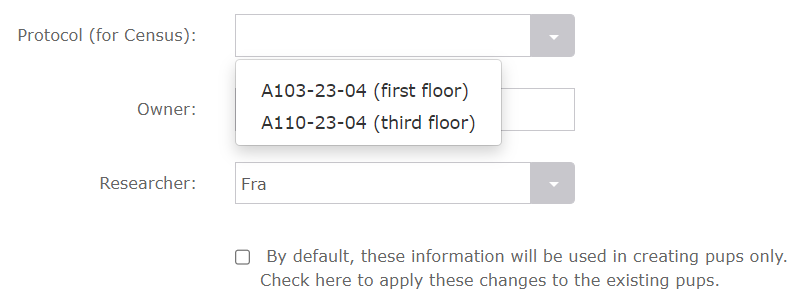

2. This script is meant to be run and mouse numbers inputted for IACUC on the same day. It will be important to keep a record of on what date weaned and born but not weaned mouse numbers were last inputted for IACUC, as this information is used in the script.

3. The same day you will run the script, go to mLIMS (https://app.mlims.com/app/mlims/index_simple.php) and select Animals, then under Review Animals select Review By Status. Click on Live to go to a list of all live animals.<br></br>
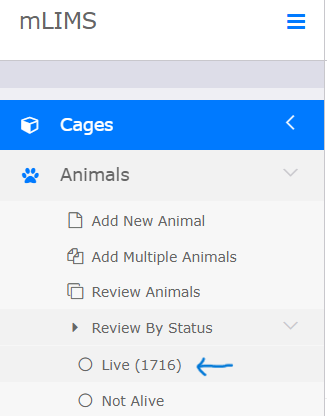


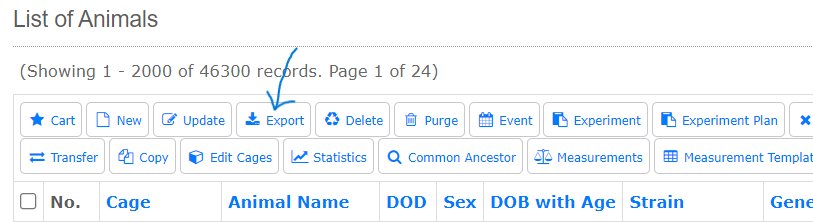


Once you are on this page, select 'Export'. Make sure to save this as a .xlsx file and title it 'Live animals' (full name should be Live animals.xlsx).


4. Just like you did when saving the 'Live animals' excel file, select Animals, then under Review Animals select Review By Status. Click on Not Alive to go to a list of all dead animals. Select 'Export'. Save this as a .xlsx file and title it 'Dead animals' (full name should be Dead animals.xlsx). <br></br>
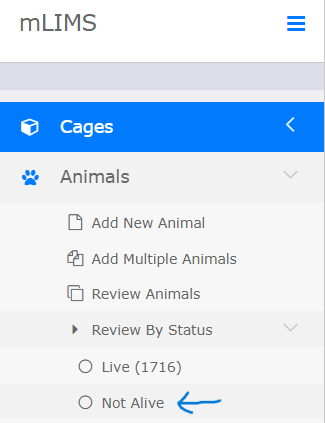



5. Run the script by going to 'Runtime' at the top of this page and clicking 'Run all'. You will need to upload the two excel files you saved where it says 'Choose Files' below, and then will be prompted to write down the date you last inputted animal numbers for IACUC at the bottom of this page. After the code finishes running, scroll to the bottom of the page again to see the animal numbers output.  
<br/><br/>


## Additional information
- *DLAR automatically counts adult mice that are transferred to our protocols (either bought or moved to our protocol from a different protocol), but they do not count the pups. This is why we need to count pups that are transferred/bought. Putting the protocol on the animal records of these pups will count them. However, the adults should not have any protocol on their records because we don't want the code to detect these mice as weaned animals, seeing as the mouse facility has already counted them. <br></br>
- Weaned animals are calculated by finding which animals became more than 28 days old during the period between today's date and the date animal numbers were last inputted for IACUC. This includes both live and dead animals. These animals are added to the total weaned for either protocol A103-23-04 or A110-23-04 depending on which protool is present on the animal record.<br></br>
- Born but not weaned animals are calculated by finding which animals of the age 28 days old or less died in the period of time since animal numbers were last inputted. They are added to the total born but not weaned for A103-23-04 or A110-23-04 depending on which protocol is present on their animal record.<br></br>
- If the mLIMS website is ever changed so that any of the columns on the live and dead animal results used by the code are absent or in a different order, this script would no longer be usable. If the columns were still there but had changed in order, the script could be updated so that the  birthdate, protocol and deathdate columns referenced in the code correspond to where they are on the animal lists. Otherwise, logic similar to that used in this script could be used to find a different strategy to count mice. <br></br>


In [1]:
from google.colab import files  #upload the Dead animals excel file you exported from mLIMS, titled "Dead animals.xlsx"
uploaded = files.upload()       #This may take some time to upload!

Saving Dead animals.xlsx to Dead animals.xlsx


In [2]:
from google.colab import files  #upload the Live animals excel file you exported from mLIMS, titled "Live animals.xlsx"
uploaded = files.upload()

Saving Live animals.xlsx to Live animals.xlsx


In [3]:
#Scroll to the bottom to answer the prompt when it appears, and then scroll to the bottom again to see the animal numbers output


import sys

import re

from openpyxl import load_workbook

Dead_animals = load_workbook(filename = "Dead animals.xlsx")
Dead = Dead_animals.active

Live_animals = load_workbook(filename = "Live animals.xlsx")
Live = Live_animals.active

from datetime import datetime

current_date = datetime.today().date()

#date of when numbers of weaned and born but not weaned animals were last inputted
last_input = input('When were new weaned and born but not weaned numbers last inputted into the Duke system?\nPlease write this date in YYYY-MM-DD format (for example, write 2023-05-10 for May 10, 2023).\n')



try:
    last_input = datetime.strptime(last_input,"%Y-%m-%d").date()
except:
    last_input = input('\nThe date must be written in YYYY-MM-DD format. Please write the date again using four digits for the year,\n a hyphen, two digits for the month, a hyphen and two digits for the day.\n')
    last_input = datetime.strptime(last_input,"%Y-%m-%d").date()



#Acquire the number of weaned animals between the current day and the last time animal numbers were inputted into the Duke webform

weaned_PR1 = 0
weaned_PR3 = 0

for cell in Live['E']: #column E contains the animal birthdates

    if type(cell.value) == str and "(" in cell.value and ")" in cell.value:
        dob_age = cell.value
        dob = dob_age[:dob_age.find(" (")]
        dob = datetime.strptime(dob,"%Y-%m-%d").date()

    elif type(cell.value) == datetime:
        dob = cell.value.date()

    else:
        continue

    lastchange = last_input - dob      #age of the mouse at the time animal numbers were last inputted for IACUC
    change = current_date - dob      #current age of the mouse

    spot = str(cell)
    startindex = spot.find(".E")
    endindex = spot.find(">")
    spotlocation = spot[startindex+2:endindex] #find the rownumber of the cell on the excel sheet

    Protocol = Live['P'+spotlocation].value #go to column P which has the protocols

    if type(Protocol) == str:

        if lastchange.days <= 28 and change.days > 28:     #if the mouse was 28 days or younger at the time of the last input, but is now older than 28 days

            if Protocol == "A103-23-04 (first floor)":
                    weaned_PR1 = weaned_PR1 + 1

            elif Protocol == "A110-23-04 (third floor)":
                    weaned_PR3 = weaned_PR3 + 1




#Acquire the number of pups which died/were sacrificed before weaning between the current day and the last time animal numbers were inputted.
#Also, add dead mice which were weaned sometime between the current day and last time animal numbers were inputted to the number of weaned animals.

born_not_weaned_PR1 = 0
born_not_weaned_PR3 = 0

for cell in Dead['E']:

    if type(cell.value) == str and "(" in cell.value and ")" in cell.value:
        DOB_age = cell.value
        DOB = DOB_age[:DOB_age.find(" (")]
        DOB = datetime.strptime(DOB,"%Y-%m-%d").date()

    elif type(cell.value) == datetime:
        DOB = cell.value.date()

    else:
        continue

    spot = str(cell)
    startindex = spot.find(".E")
    endindex = spot.find(">")
    spotlocation = spot[startindex+2:endindex] #find the rownumber of the cell on the excel sheet

    has_DOD = Dead['C'+spotlocation].value #go to column C of that row

    if type(has_DOD) == datetime:
        DOD = has_DOD.date()

        if not (DOD - last_input).days <= 0:     #if the mouse died after the last input date

            protocol = Dead['P'+spotlocation].value

            if type(protocol) == str:

                if (DOD - DOB).days <= 28:     #if the mouse was 28 days old or less, add to born but not weaned

                  if protocol == "A103-23-04 (first floor)":
                      born_not_weaned_PR1 = born_not_weaned_PR1 + 1

                  elif protocol == "A110-23-04 (third floor)":
                      born_not_weaned_PR3 = born_not_weaned_PR3 + 1

                elif (DOD - DOB).days > 28 and (last_input - DOB).days <= 28:     #if the mouse was over 28 days old at time of death and became older than 28 days after the last input date

                  if protocol == "A103-23-04 (first floor)":
                      weaned_PR1 = weaned_PR1 + 1

                  elif protocol == "A110-23-04 (third floor)":
                      weaned_PR3 = weaned_PR3 + 1




print("\n\nProtocol A103-23-04\nTotal number of weaned animals to be inputed for the period of {} to {}: {}.\nTotal number of born but not weaned animals to be inputed for this period: {}.\n\n".format(last_input,current_date,weaned_PR1,born_not_weaned_PR1))

print("Protocol A110-23-04\nTotal number of weaned animals to be inputed for the period of {} to {}: {}.\nTotal number of born but not weaned animals to be inputed for this period: {}.".format(last_input,current_date,weaned_PR3,born_not_weaned_PR3))





When were new weaned and born but not weaned numbers last inputted into the Duke system?
Please write this date in YYYY-MM-DD format (for example, write 2023-05-10 for May 10, 2023).
2023-09-08


Protocol A103-23-04
Total number of weaned animals to be inputed for the period of 2023-09-08 to 2023-10-08: 291.
Total number of born but not weaned animals to be inputed for this period: 254.


Protocol A110-23-04
Total number of weaned animals to be inputed for the period of 2023-09-08 to 2023-10-08: 90.
Total number of born but not weaned animals to be inputed for this period: 13.
